**This notebook introduces how to train a conditional VAE model from scratch. <br/>**
We first use an encoder to compress the high-dimensional temperature data into latent vectors. Then, we incorporate CO2 & CH4 information into latent vectors, and use an decorder to reconstruct the global temperature map.

By Weiwei Zhan

Reference: https://towardsdatascience.com/variational-autoencoders-as-generative-models-with-keras-e0c79415a7eb

vary latent space - modify by Rong-Yu Gu, 10/10/23

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

import torch
import torch.nn as nn
import torch.nn.functional as F
from utils import * 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
cwd = os.getcwd()
train_path = "gs://leap-persistent/jbusecke/data/climatebench/train_val/"
test_path = "gs://leap-persistent/jbusecke/data/climatebench/test/"

### 1. data preprocssing: prepare data for training & test sets

In [4]:
# Training set
train_files = ["historical", "ssp585", "ssp126", "ssp370","hist-GHG","hist-aer"]
X_train_xr, X_length  = prepare_predictor(train_files,train_path)
y_train_xr, y_length  = prepare_predictand(train_files,train_path)

# Test set
X_test_xr, _ = prepare_predictor('ssp245', data_path=test_path,time_reindex=False)
y_test_xr, _ = prepare_predictand('ssp245',data_path=test_path,time_reindex=False)


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

#### Data normalization

normalize the CO2 & CH4 time series

In [5]:
X_train_df = pd.DataFrame({"CO2": X_train_xr["CO2"].data,
                           "CH4": X_train_xr["CH4"].data
                          }, index=X_train_xr["CO2"].coords['time'].data)

X_test_df  = pd.DataFrame({"CO2": X_test_xr["CO2"].data,
                           "CH4": X_test_xr["CH4"].data
                          }, index=X_test_xr["CO2"].coords['time'].data)

# Normalization
mean, std = X_train_df.mean(), X_train_df.std()

X_train_df   = (X_train_df - mean)/std
X_test_df    = (X_test_df - mean)/std

X_train = X_train_df.to_numpy()
X_test = X_test_df.to_numpy()

print(X_train.shape,X_test.shape)

(753, 2) (86, 2)


normalize the 2-D temperature data 

In [6]:
var  = 'tas'
y_train = y_train_xr[var].data
y_test  = y_test_xr[var].data

mean = y_train.mean()
std  = y_train.std()

y_train = (y_train - mean)/std
y_test  = (y_test - mean)/std

y_train = np.expand_dims(y_train, -1).astype("float32") 
y_test  = np.expand_dims(y_test, -1).astype("float32") 

n_lat, n_lon = y_train.shape[1], y_train.shape[2]
print(y_train.shape,y_test.shape)

(753, 96, 144, 1) (86, 96, 144, 1)


In [41]:
# Convert to PyTorch datasets
train_dataset = torch.utils.data.TensorDataset(torch.FloatTensor(X_train), \
                                               torch.FloatTensor(y_train))
test_dataset = torch.utils.data.TensorDataset(torch.FloatTensor(X_test), torch.FloatTensor(y_test))

# Split into train and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

### 2. Define the VAE architecture

![VAE_structure](https://drive.google.com/uc?export=view&id=1yVOTtfQTJEEijNWldOhNk3grO6QNT28E)


figure source: https://lilianweng.github.io/posts/2018-08-12-vae/

In [17]:
latent_dim = 2   # dimensions of the latent space
n_filters  = 32  # number of filters for the convolutional layers
n_neurons  = 64  # number of neurons for the Dense layers
activation = nn.ReLU() # activation function
kernel_size = 4
learning_rate = 0.001
minibatch_size = 64
num_epochs     = 80

In [18]:
# Create data loaders for batched training
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=minibatch_size, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=minibatch_size, shuffle=False)

In [19]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (753, 2)
y_train shape: (753, 96, 144, 1)


#### Build Encoder & Sampling for the latent vector

In [20]:
class Encoder(nn.Module):
    def __init__(self, n_filters, kernel_size, n_neurons, latent_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(1, n_filters, kernel_size, stride=2, padding=1)   # (96,144,1) -> (48,72,32)
        self.conv2 = nn.Conv2d(n_filters, n_filters, kernel_size, stride=2, padding=1) # (48,72,32) -> (24,36,32)
        self.conv3 = nn.Conv2d(n_filters, n_filters, kernel_size, stride=2, padding=1) # (24,36,32) -> (12,18,32)

        self.flatten = nn.Flatten()
        self.fc = nn.Linear(12 * 18 * n_filters, n_neurons)

        self.z_mean = nn.Linear(n_neurons, latent_dim)
        self.z_log_var = nn.Linear(n_neurons, latent_dim)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.conv1(x))
        x = self.activation(self.conv2(x))
        x = self.activation(self.conv3(x))
        x = self.flatten(x)
        x = self.activation(self.fc(x))
        z_mean = self.z_mean(x)
        z_log_var = self.z_log_var(x)
        return z_mean, z_log_var


# sampling
def sample_latent(z_mean, z_log_var):
    eps = torch.randn_like(z_log_var)
    return z_mean + torch.exp(0.5 * z_log_var) * eps

#### Build Decoder

Here we additionally include CO2 & CH4 as Decoder inputs (the `cond_input` variable)

In [21]:
class Decoder(nn.Module):
    def __init__(self, n_filters, kernel_size, n_neurons, latent_dim):
        super().__init__()
        self.fc = nn.Linear(latent_dim, 12 * 18 * n_filters)
        self.deconv1 = nn.ConvTranspose2d(
            n_filters, n_filters, kernel_size=kernel_size,
            stride=2, padding=1, output_padding=0)
        self.deconv2 = nn.ConvTranspose2d(
            n_filters, n_filters, kernel_size=kernel_size,
            stride=2, padding=1, output_padding=0)
        self.deconv3 = nn.ConvTranspose2d(
            n_filters, n_filters, kernel_size=kernel_size,
            stride=2, padding=1, output_padding=0)
        self.final = nn.Conv2d(n_filters, 1, kernel_size=3, stride=1, padding=1)
        self.activation = nn.ReLU()

    def forward(self, z):
        x = self.activation(self.fc(z))
        x = x.view(-1, n_filters, 12, 18)
        x = self.activation(self.deconv1(x))
        x = self.activation(self.deconv2(x))
        x = self.activation(self.deconv3(x))
        x = self.final(x)
        return x

#### Build the conditional VAE

In [22]:
class VAE(nn.Module):
    def __init__(self, n_filters, kernel_size, n_neurons, latent_dim, cond_dim=2):
        super().__init__()
        self.encoder = Encoder(n_filters, kernel_size, n_neurons, latent_dim)
        self.decoder = Decoder(n_filters, kernel_size, n_neurons, latent_dim + cond_dim)
        self.cond_dim = cond_dim

    def forward(self, x, cond):
        z_mean, z_log_var = self.encoder(x)
        z = sample_latent(z_mean, z_log_var)
        # Concatenate condition (CO2, CH4) with z
        z_cond = torch.cat([z, cond], dim=1)
        recon = self.decoder(z_cond)
        return recon, z_mean, z_log_var

In [23]:
vae = VAE(n_filters, kernel_size, n_neurons, latent_dim).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=learning_rate)

#### Define the loss function: reconstruction loss + KL loss

In [24]:
def vae_loss(y_true, y_pred, z_mean, z_log_var):
    # Reconstruction loss (MSE)
    recon_loss = F.mse_loss(y_pred, y_true, reduction='mean')

    # KL divergence
    kl_loss = -0.5 * torch.mean(1 + z_log_var - z_mean.pow(2) - z_log_var.exp())

    # Multiply recon_loss by 96*144 as in Keras version
    total_loss = recon_loss * n_lat * n_lon + kl_loss
    return total_loss

### 3. Train the VAE model

this can be slow on CPUs

In [25]:
train_losses, val_losses = pytorch_train_VAE(vae.to(device), optimizer, criterion = vae_loss, device = device, 
                                         train_loader = train_loader, 
                                         val_loader = val_loader, 
                                         num_epochs = num_epochs)

Epoch 1/80, Train Loss: 14279.1855, Val Loss: 16004.7230
Epoch 2/80, Train Loss: 13429.2567, Val Loss: 16119.4557
Epoch 3/80, Train Loss: 13408.7462, Val Loss: 16001.4945
Epoch 4/80, Train Loss: 13150.3053, Val Loss: 15488.5550
Epoch 5/80, Train Loss: 12417.9432, Val Loss: 13723.5986
Epoch 6/80, Train Loss: 15751.0187, Val Loss: 16719.8027
Epoch 7/80, Train Loss: 13108.7846, Val Loss: 15237.1048
Epoch 8/80, Train Loss: 12440.0067, Val Loss: 14729.0553
Epoch 9/80, Train Loss: 11734.3740, Val Loss: 14067.0140
Epoch 10/80, Train Loss: 11086.5715, Val Loss: 13423.3304
Epoch 11/80, Train Loss: 10324.2736, Val Loss: 12140.6237
Epoch 12/80, Train Loss: 8397.8689, Val Loss: 8953.7943
Epoch 13/80, Train Loss: 5691.9927, Val Loss: 4912.4793
Epoch 14/80, Train Loss: 3328.9841, Val Loss: 3613.8359
Epoch 15/80, Train Loss: 2727.9857, Val Loss: 3064.3389
Epoch 16/80, Train Loss: 2445.0708, Val Loss: 2623.4216
Epoch 17/80, Train Loss: 2208.9888, Val Loss: 2484.6922
Epoch 18/80, Train Loss: 2088.3611,

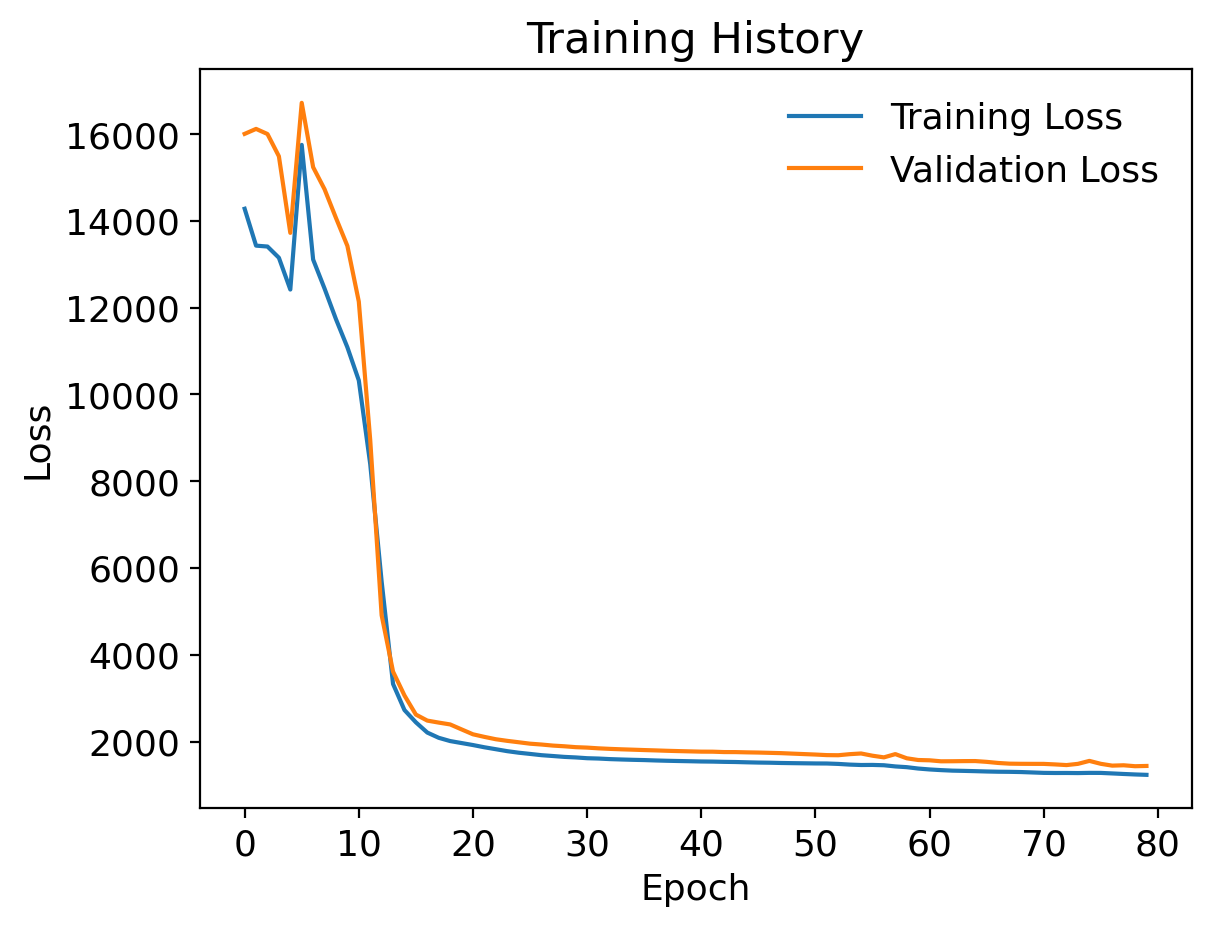

In [26]:
plot_history(train_losses, val_losses)

### 4. evaluate the model performance

Let's test the reconstruction capabilities of our VAE model on the test set.

In [50]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=minibatch_size, shuffle=False)

vae.eval()
predictions = []
z_all = []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)  # shape: (batch_size, 2)
        batch_y = batch_y.permute(0, 3, 1, 2).float().to(device)
        recon, z_mean, _ = vae(batch_y, batch_X)
        predictions.append(recon.cpu().numpy())
        z_all.append(z_mean.cpu().numpy())
        

# concatenate all batches
z_all = np.concatenate(z_all, axis=0)
y_test_pre = np.concatenate(predictions, axis=0)

# remove channel dim if needed
y_test_pre = y_test_pre.squeeze()  # shape: (N, 96, 144)

# wrap as xarray Dataset
y_test_pre = xr.Dataset(
    coords={'time': X_test_xr.time.values, 
            'latitude': X_test_xr.latitude.values, 
            'longitude': X_test_xr.longitude.values},
    data_vars=dict(tas=(['time', 'latitude', 'longitude'], y_test_pre))
)


Comparisons in terms of the spatial distribution

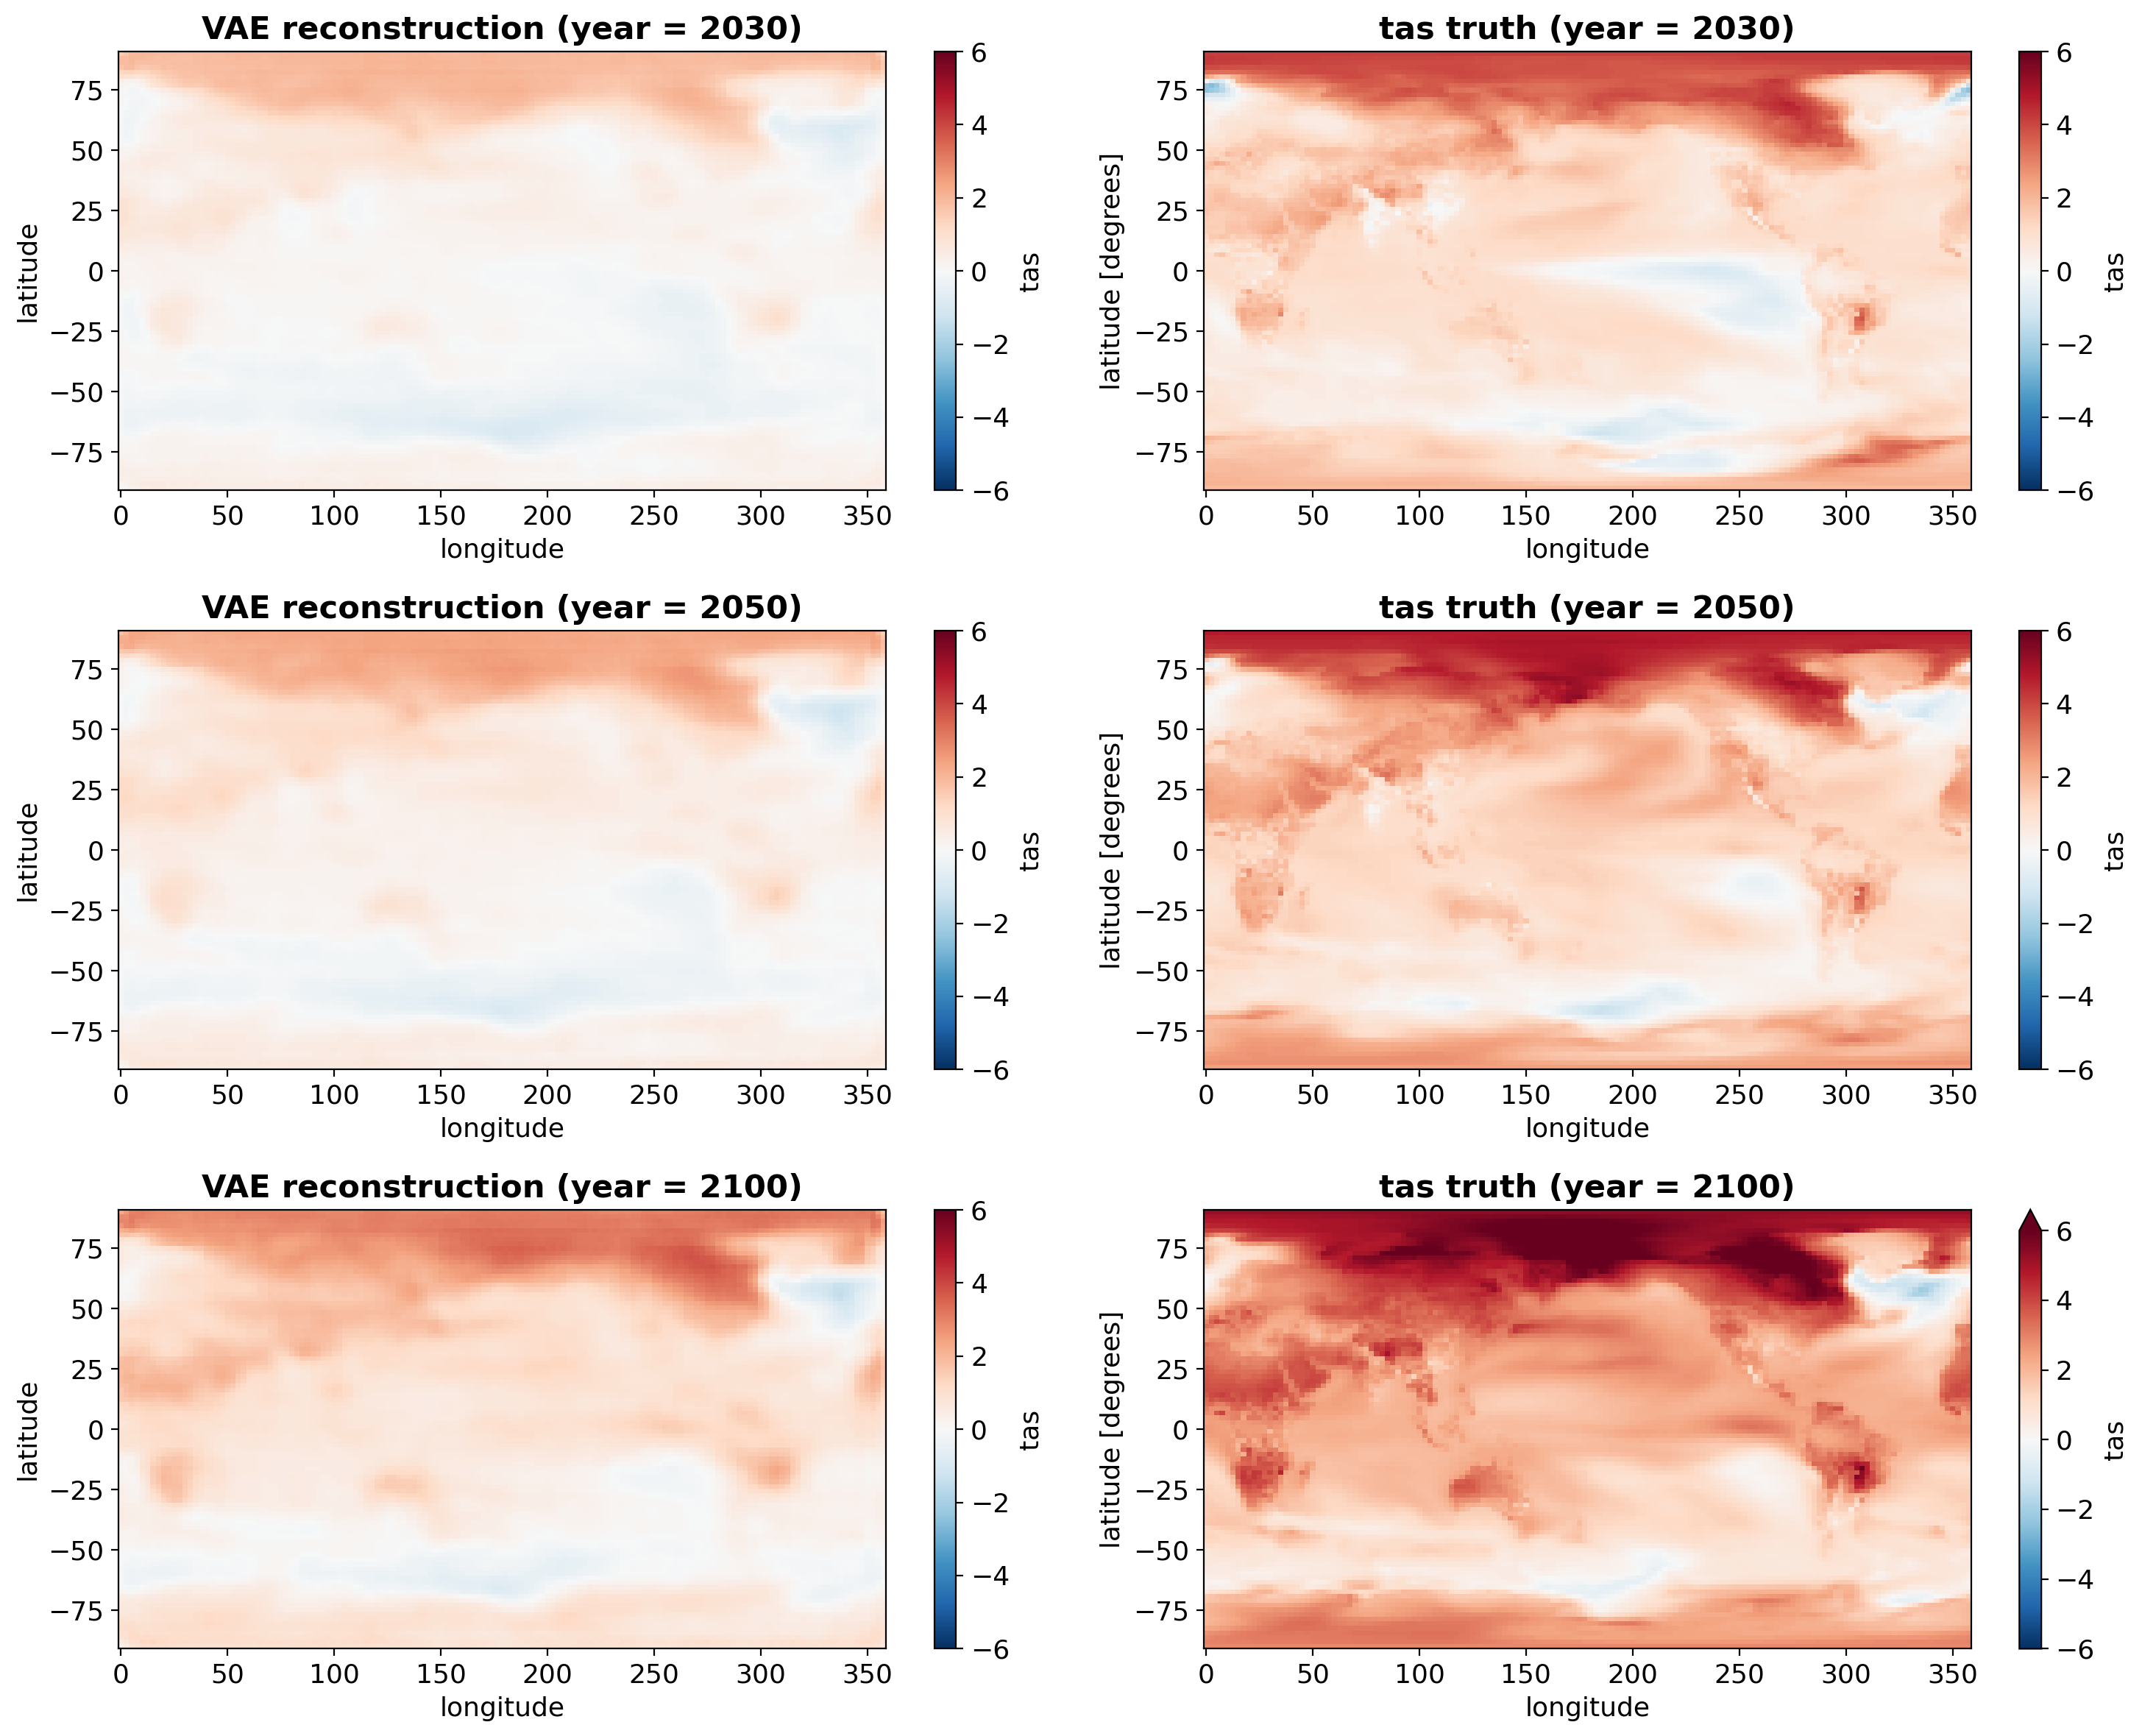

In [51]:
fig, axes = plt.subplots(figsize=(15,12),ncols=2,nrows=3)

yrs = [2030, 2050, 2100]
vmin, vmax    = -6, 6
cmap = 'RdBu_r'
y_test_pre.tas.sel(time=yrs[0]).plot(ax=axes[0,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.tas.sel(time=yrs[0]).plot(ax=axes[0,1], vmin=vmin, vmax=vmax,cmap=cmap)

y_test_pre.tas.sel(time=yrs[1]).plot(ax=axes[1,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.tas.sel(time=yrs[1]).plot(ax=axes[1,1], vmin=vmin, vmax=vmax,cmap=cmap)

y_test_pre.tas.sel(time=yrs[2]).plot(ax=axes[2,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.tas.sel(time=yrs[2]).plot(ax=axes[2,1], vmin=vmin, vmax=vmax,cmap=cmap)


for i, ax in enumerate(axes.flat):
    # left column: model prediction
    if i % 2 == 0:
        ax.set_title(f'VAE reconstruction (year = {yrs[i//2]})',fontweight='bold')
    # right column: truth tas from ssp245 simulations
    else:
        ax.set_title(f'tas truth (year = {yrs[i//2]})',fontweight='bold')
plt.tight_layout()

Comparisons in terms of the temporal variability (under the ssp245 scenario)

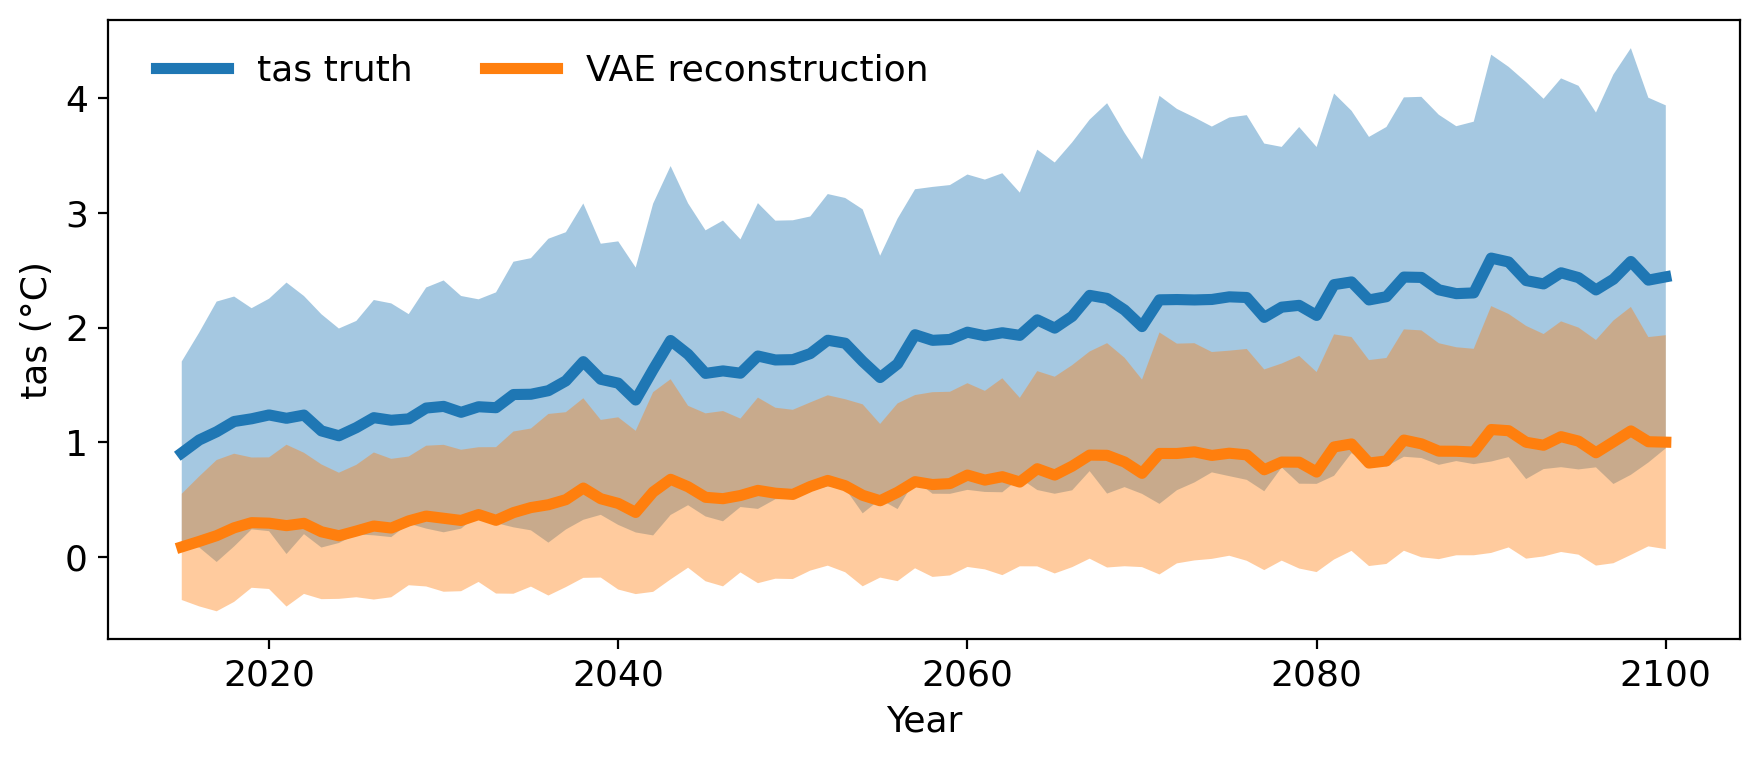

In [52]:
fig, ax = plt.subplots(figsize=(9,4))

yr,mean_truth = mean_std_plot(y_test_xr['tas'],color='tab:blue',label='tas truth',ax=ax)
yr,mean_pre   = mean_std_plot(y_test_pre['tas'],color='tab:orange',label='VAE reconstruction',ax=ax)

ax.set_xlabel('Year')
ax.set_ylabel('tas (°C)')


fig.legend(loc='upper left',bbox_to_anchor=(0.08,0.95),ncol=2)


plt.tight_layout()

### 5. check how the latent space affect model output

Here we display a simple way to show how the latent space affect model output. We vary z in each dimension respectively and pass it through the decoder, which means the decoder is conditioned on a different z value. Then, we plot and compare the model output between the original z and a varied z.

First, let's look at the distribution of z in each dimension.


shape of latent space =  (86, 2)
latent space for the first 5 years of test data =  tensor([[ 0.9448, -0.6060],
        [ 0.2649, -1.7171],
        [-0.0623, -0.3004],
        [-1.2962,  0.4405],
        [ 1.0509,  0.7663]], device='cuda:0')


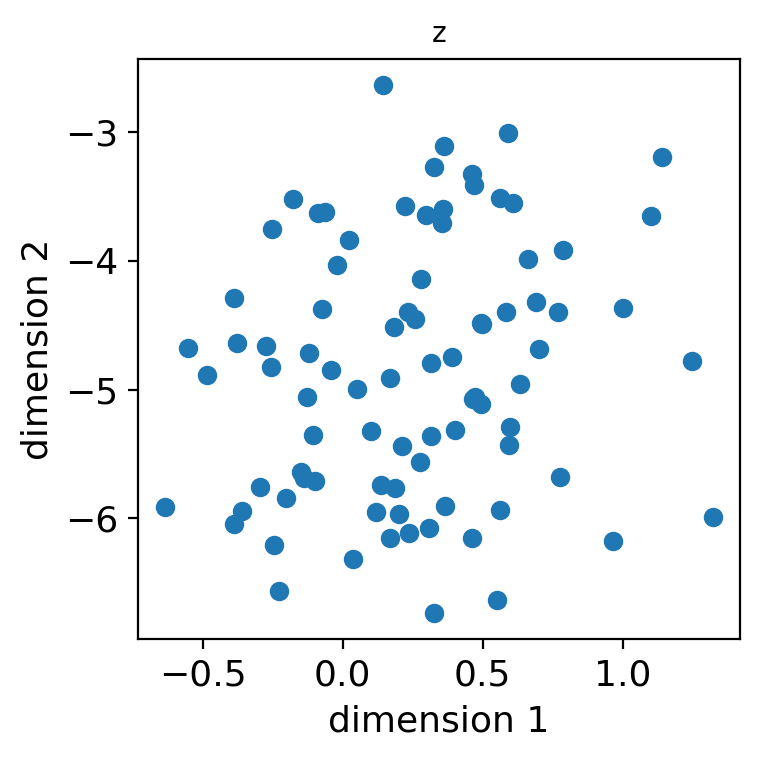

In [54]:
from scipy.stats import norm

### visualize the latent space (z)
print("shape of latent space = ", np.shape(z_all)) # shape of z = (test_years, latent_dim)
print("latent space for the first 5 years of test data = ", z[0:5,:])

# fit a normal distribution on z
mu_fit1, std_fit1 = norm.fit(z_all[:,0])
mu_fit2, std_fit2 = norm.fit(z_all[:,1])

## plot z
fig, ax = plt.subplots(figsize=(4,4))

plt.scatter(z_all[:,0],z_all[:,1])

plt.title("z", fontsize=10)
plt.xlabel('dimension 1')
plt.ylabel('dimension 2')
plt.tight_layout()



Then, we vary z as a arbitary value in each dimension respectively. In this example, we only implement a varied z in the first year of the output (year = 2015).

In [58]:
### varying latent space
# dimension 1
z1 = np.copy(z_all)
z1[[0],0] = -2 # vary latent space dimension 1 at year 2015 (first year of the test data)
print("original z[[0],0] = ", np.round(z_all[[0],0], 4), ", new z[[0],0] =", np.round(z1[[0],0],4))

# pass the new z to the decoder
# convert to torch tensors
z1_tensor = torch.FloatTensor(z1).to(device)
X_test_tensor = torch.FloatTensor(X_test).to(device)

# concatenate z + X
decoder_input = torch.cat([z1_tensor, X_test_tensor], dim=1)

# pass through decoder
vae.eval()
with torch.no_grad():
    y_test_pre_varyz1 = vae.decoder(decoder_input).cpu().numpy()

y_test_pre_varyz1 = y_test_pre_varyz1*std + mean

# save the output as an xarray
y_test_pre_varyz1 = y_test_pre_varyz1.reshape(y_test_pre_varyz1.shape[0], 96, 144)
y_test_pre_varyz1 = xr.Dataset(coords={'time': y_test_xr.time.values, 
                               'latitude': y_test_xr.latitude.values, 
                               'longitude': y_test_xr.longitude.values},
                       data_vars=dict(tas=(['time', 'latitude', 'longitude'], y_test_pre_varyz1)))


# dimension 2
z2 = np.copy(z_all)
z2[[0],1] = -1 # vary latent space dimension 2 at year 2015
print("original z[[0],1] = ", np.round(z_all[[0],1], 4), ", new z[[0],1] =", np.round(z2[[0],1],4))

# convert to torch tensors
z2_tensor = torch.FloatTensor(z2).to(device)

# concatenate z + X
decoder_input = torch.cat([z2_tensor, X_test_tensor], dim=1)

# pass through decoder
vae.eval()
with torch.no_grad():
    y_test_pre_varyz2 = vae.decoder(decoder_input).cpu().numpy()

y_test_pre_varyz2 = y_test_pre_varyz2*std + mean

y_test_pre_varyz2 = y_test_pre_varyz2.reshape(y_test_pre_varyz2.shape[0], 96, 144)
y_test_pre_varyz2 = xr.Dataset(coords={'time': y_test_xr.time.values, 
                               'latitude': y_test_xr.latitude.values, 
                               'longitude': y_test_xr.longitude.values},
                       data_vars=dict(tas=(['time', 'latitude', 'longitude'], y_test_pre_varyz2)))

original z[[0],0] =  [0.1448] , new z[[0],0] = [-2.]
original z[[0],1] =  [-2.6366] , new z[[0],1] = [-1.]


Compare the varied z output with the original output

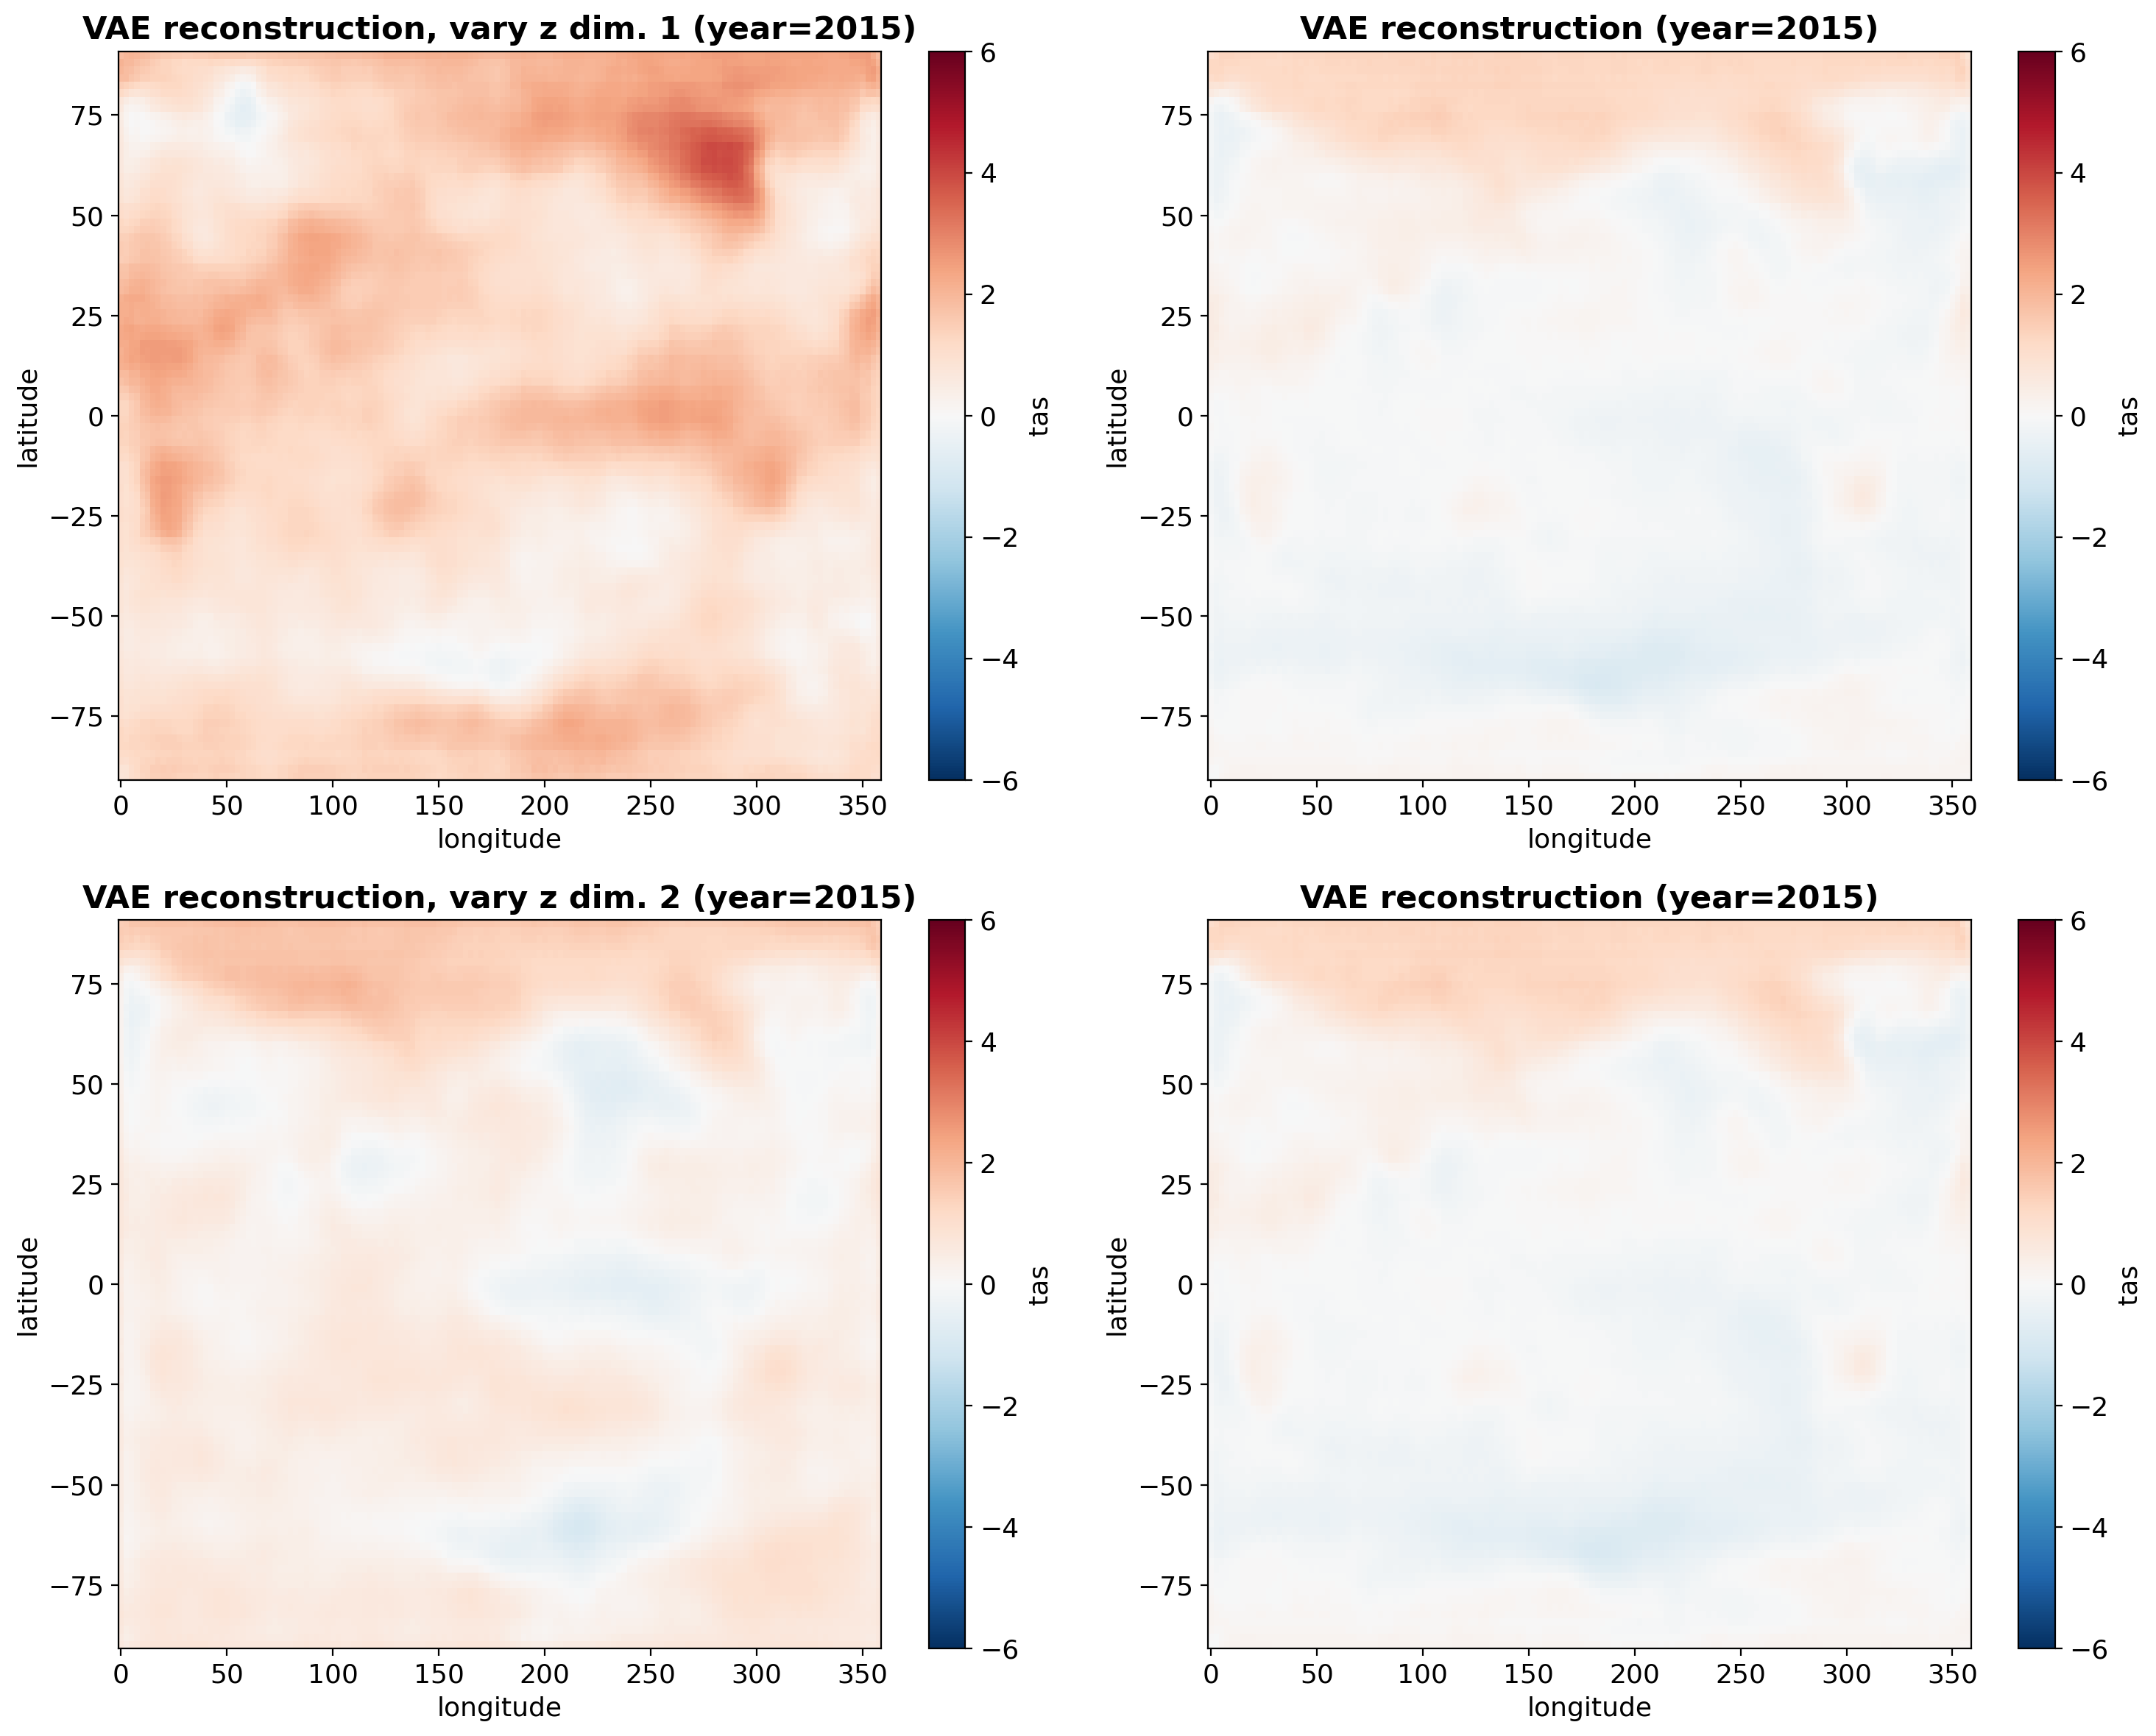

In [59]:
fig, axes = plt.subplots(figsize=(15,12),ncols=2,nrows=2)

vmin, vmax    = -6, 6
cmap = 'RdBu_r'
y_test_pre_varyz1.tas.sel(time=2015).plot(ax=axes[0,0], vmin=vmin, vmax=vmax,cmap=cmap)
axes[0,0].set_title(f'VAE reconstruction, vary z dim. 1 (year=2015)',fontweight='bold')

y_test_pre.tas.sel(time=2015).plot(ax=axes[0,1], vmin=vmin, vmax=vmax,cmap=cmap)
axes[0,1].set_title(f'VAE reconstruction (year=2015)',fontweight='bold')

y_test_pre_varyz2.tas.sel(time=2015).plot(ax=axes[1,0], vmin=vmin, vmax=vmax,cmap=cmap)
axes[1,0].set_title(f'VAE reconstruction, vary z dim. 2 (year=2015)',fontweight='bold')

y_test_pre.tas.sel(time=2015).plot(ax=axes[1,1], vmin=vmin, vmax=vmax,cmap=cmap)
axes[1,1].set_title(f'VAE reconstruction (year=2015)',fontweight='bold')

plt.tight_layout()